In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc

from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## 1. Set ups

### 1.1. Load models & scaler

In [2]:
# Load all sklearn models
with open("./model/sklearn/err_all_sklearn.pkl", "rb") as f:
    sklearn_models = pickle.load(f)

# Load all deep learning models
with open("./model/dp/all_models.pkl", "rb") as f:
    dp_models = pickle.load(f)

# Load input scaler
with open("./model/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

2022-11-27 13:04:59.224051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 13:04:59.224496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



### 1.2. Important functions

In [3]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

## 2. Process Test set

In [5]:
# load dataset
test_df = describe_dataset("./err.test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "C", "label"] = 1
test_df.loc[test_df["label"] == "L", "label"] = 0

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 1107 
Number of columns: 53

Labels: 
L    561
C    546
Name: label, dtype: int64

Missing values: Fa

## 2. Test set evaluation for all models

### 2.1. Sklearn models evaluation

In [6]:
testset_final_results = []

for name, model in sklearn_models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[1, 0])
    testset_final_results.append(( name,  p_score, a_score, r_score, f1_score_result, cm ))


sklearn_eval = pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Accuracy Score", "Recall Score", "F1 Score", "Confusion Matrix"])

sklearn_eval

,Model,Precision Score,Accuracy Score,Recall Score,F1 Score,Confusion Matrix
0,LR,0.973314,0.971996,0.971996,0.971987,"[[545, 1], [30, 531]]"
1,SVC,0.751947,0.719964,0.719964,0.711815,"[[488, 58], [252, 309]]"
2,KNN,0.768403,0.765131,0.765131,0.764652,"[[445, 101], [159, 402]]"
3,DTC,0.919226,0.916893,0.916893,0.916730,"[[479, 67], [25, 536]]"
4,SGDC,0.960628,0.957543,0.957543,0.957496,"[[545, 1], [46, 515]]"
5,NB,0.770355,0.768744,0.768744,0.768213,"[[395, 151], [105, 456]]"
6,RF,0.854529,0.841915,0.841915,0.840738,"[[510, 36], [139, 422]]"


### 2.2. Deep learning models

In [7]:
test_set_results = []

for name, model in dp_models.items():
    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[1, 0])
    p_score = precision_score(y_test_class, y_pred_class, average="weighted")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="weighted")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="weighted")
    
    test_set_results.append(( name,  (p_score), a_score, (r_score), (f1_score_result), cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model", "Precision Score", "Accuracy Score", "Recall Score", "F1 Score", "Confusion Matrix"])

dp_eval

2022-11-27 13:05:38.881823: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 13:05:38.941570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 13:05:39.153747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 13:05:39.316420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 13:05:39.450061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Precision Score,Accuracy Score,Recall Score,F1 Score,Confusion Matrix
0,7_layers_with_dropout,0.892070,0.864499,0.864499,0.862354,"[[544, 2], [148, 413]]"
1,5_layers,0.860509,0.831075,0.831075,0.827950,"[[531, 15], [172, 389]]"
2,3_layers,0.936507,0.927733,0.927733,0.927442,"[[545, 1], [79, 482]]"
3,7_layers,0.837910,0.773261,0.773261,0.762745,"[[541, 5], [246, 315]]"


### 2.3. Final Results

In [8]:
eval_df = pd.concat([sklearn_eval, dp_eval])
eval_df = eval_df.sort_values(by=['F1 Score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"err.evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision Score,Accuracy Score,Recall Score,F1 Score,Confusion Matrix
0,LR,0.973314,0.971996,0.971996,0.971987,"[[545, 1], [30, 531]]"
1,SGDC,0.960628,0.957543,0.957543,0.957496,"[[545, 1], [46, 515]]"
2,3_layers,0.936507,0.927733,0.927733,0.927442,"[[545, 1], [79, 482]]"
3,DTC,0.919226,0.916893,0.916893,0.916730,"[[479, 67], [25, 536]]"
4,7_layers_with_dropout,0.892070,0.864499,0.864499,0.862354,"[[544, 2], [148, 413]]"
5,RF,0.854529,0.841915,0.841915,0.840738,"[[510, 36], [139, 422]]"
6,5_layers,0.860509,0.831075,0.831075,0.827950,"[[531, 15], [172, 389]]"
7,NB,0.770355,0.768744,0.768744,0.768213,"[[395, 151], [105, 456]]"
8,KNN,0.768403,0.765131,0.765131,0.764652,"[[445, 101], [159, 402]]"
9,7_layers,0.837910,0.773261,0.773261,0.762745,"[[541, 5], [246, 315]]"


## 3. Best model - ROC - Confusion Matrix

As we can see from the evaluation, the best model according to the F1 Score is the LR model.

In [21]:
best_model = sklearn_models["LR"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

(array([0.9981203 , 0.94782609]),
 array([0.94652406, 0.9981685 ]),
 array([0.97163769, 0.97234612]))

In [22]:
(0.998 + 0.947) / 2

0.9724999999999999

### 3.1. Confusion Matrix

<AxesSubplot:>

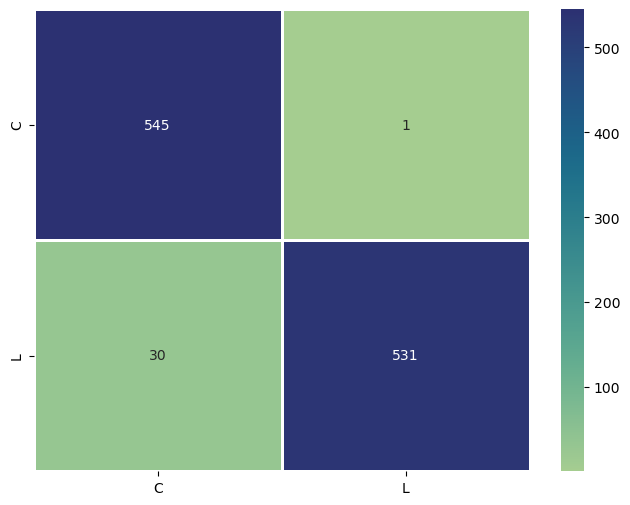

In [11]:
KNN_cm = eval_df[ eval_df["Model"] == 'LR' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(KNN_cm, index=["C", "L"], columns=["C", "L"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")

### 3.3. F1 Score and Confidence correlation

In [23]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model.predict(test_x)
    y_predict_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.05, 0.01))

    f1_score_results = []

    for threshold in thresholds:
        true_predictions = to_labels(y_predictions, y_predict_proba, threshold)
        f1_s = list(f1_score(test_y, true_predictions, labels=[1, 0], average=None))
        all_class_f1 = f1_score(test_y, true_predictions, labels=[0, 1, 2], average="weighted")
        f1_s.append(all_class_f1)
        f1_score_results.append(f1_s)
    
    return thresholds, f1_score_results



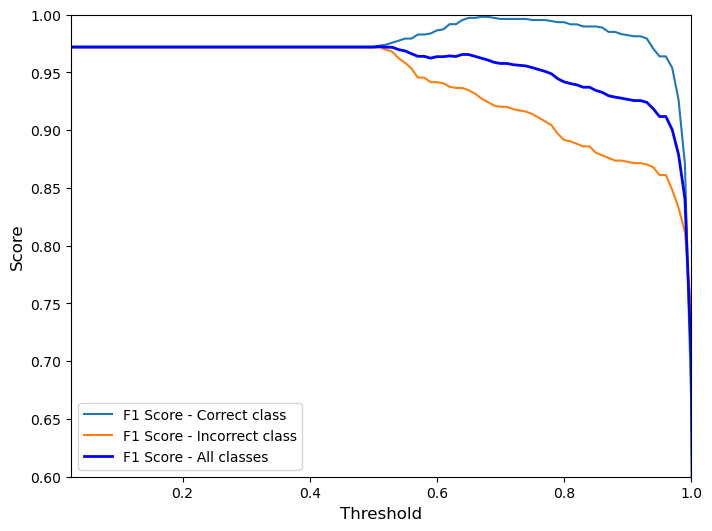

In [24]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [ el[2] for el in f1_scores ]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.6, 1])
plt.xlim([0.025, 1])
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("F1 Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

### 3.2. ROC curve

Optimal Threshold: 0.6863927762156125


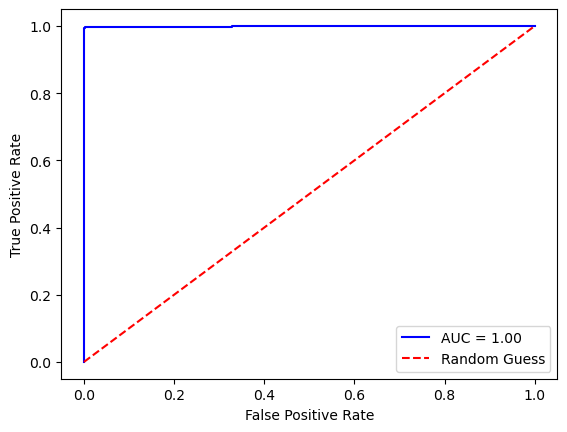

In [19]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Guess")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()